Tumor Image Classification Paper link: https://docs.google.com/document/d/1w7NgH1h2Js1KENZPmnw8YTDOEDy43bcK18R1m3Ygkj4/edit?usp=sharing

Original Dataset Link: https://zenodo.org/records/1214456

Images and Saved Models: https://drive.google.com/drive/u/1/folders/1RdJ5tLB14gDJxjM7sBxf5tk4WIAB7TI5

In [ ]:
# imports
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten, Dropout
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import os
from PIL import Image
from tensorflow import keras
import tensorflow as tf
tf.config.run_functions_eagerly(True)
from tensorflow.keras.models import load_model


To use on google colab go to: https://drive.google.com/drive/folders/1RdJ5tLB14gDJxjM7sBxf5tk4WIAB7TI5?usp=sharing

Click “Add shortcut to Drive”.

Choose a location “My Drive”.

In [ ]:
# to access data
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# data (plus set up)
folder_path = '/content/drive/MyDrive/Cancer Images'
Tumor_path = os.path.join(folder_path, 'TUM')
Normal_path = os.path.join(folder_path, 'NORM')

In [ ]:
print("amount of Tumor images: ", len([f for f in os.listdir(Tumor_path) if f.lower().endswith(('.png'))]))
print("amount of Normal images: ", len([f for f in os.listdir(Normal_path) if f.lower().endswith(('.png'))]))

amount of Tumor images:  8835
amount of Normal images:  8763


In [ ]:
#augmentation
data_augmentation = tf.keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomFlip("vertical"),
    keras.layers.RandomRotation(0.05),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomContrast(0.2),
    keras.layers.GaussianNoise(0.05)
])

In [ ]:
# train test split
class_names = ['TUM', 'NORM']
image_height = 224
image_width = 224
batch_size = 32

train_data = tf.keras.preprocessing.image_dataset_from_directory(
    folder_path,
    validation_split=0.2,
    shuffle=True,
    subset='training',
    seed=1,
    image_size=(image_width,image_height),
    batch_size=batch_size,
    class_names=class_names
)
test_data = tf.keras.preprocessing.image_dataset_from_directory(
    folder_path,
    validation_split=0.2,
    shuffle=True,
    subset='validation',
    seed=1,
    image_size=(image_width,image_height),
    batch_size=batch_size,
    class_names=class_names
)
train_data = train_data.map(lambda x, y: (data_augmentation(x, training=True), y))
train_data = train_data.cache().prefetch(tf.data.AUTOTUNE)
test_data = test_data.cache().prefetch(tf.data.AUTOTUNE)


Found 17598 files belonging to 2 classes.
Using 14079 files for training.


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


Found 17598 files belonging to 2 classes.
Using 3519 files for validation.


In [ ]:
# model
model = Sequential()

# Normalization
model.add(tf.keras.layers.Rescaling(1./255))

# Convolutional Layers
model.add(Conv2D(32, 3, activation="relu", input_shape=(image_height, image_width, 3)))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64,3,activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D((2,2)))
model.add(Conv2D(128,3,activation="relu"))
model.add(tf.keras.layers.BatchNormalization())
model.add(MaxPooling2D((3,3)))
model.add(tf.keras.layers.Dropout(0.25))
# Flatten and Fully Connected Layers
model.add(Flatten())
model.add(Dense(128, activation="relu"))
model.add(tf.keras.layers.BatchNormalization())

# Dropout to prevent overfitting
model.add(tf.keras.layers.Dropout(0.3))

# Output layer
model.add(Dense(1, activation="sigmoid"))

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [ ]:
# compiler (for first use only)
model.compile(
    loss='binary_crossentropy',
    optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
    metrics=['accuracy']
)

In [ ]:
# Checkpoint to save the model
# NOTE: We could not find a way to monitor both accuracy and auc, so for the ones we save in the Cancer folder, I had to manually add it
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint(
    filepath='/content/checkpoints/model_epoch_acc_{accuracy:.4f}_auc.h5',
    monitor='accuracy',
    save_weights_only=False,
    #save_best_only=True,
    save_freq=50,  # Save every x batches
    verbose=1
)


In [ ]:
# fit model (first use only)
history = model.fit(
train_data,
epochs=1,
validation_data=test_data,
callbacks=[checkpoint]
)


NameError: name 'checkpoint' is not defined

In [ ]:
# All models saved in colab
checkpoint_dir = '/content/checkpoints'
if os.path.exists(checkpoint_dir):
    checkpoints = sorted(os.listdir(checkpoint_dir))
    print("Available checkpoints:")
    for ckpt in checkpoints:
        print(ckpt)
else:
    print("Directory does not exist.")

In [ ]:
#Save a model
os.makedirs(folder_path, exist_ok=True)
model.save(os.path.join(folder_path, 'model_epoch_08_valacc_0.9450.h5'))

In [ ]:
# Training saved models
from tensorflow.keras.models import load_model
from tensorflow.keras.optimizers import Adam

# loads model saved in colab/drive
#model = load_model(folder_path + "/model_epoch_01_valacc_0.9094.h5")
model = load_model('/content/checkpoints/model_epoch_08_valacc_0.9300.h5')

optimizer = tf.keras.optimizers.Adam(learning_rate=0.001)
loss = tf.keras.losses.BinaryCrossentropy(label_smoothing=0.05)
model.compile(
    optimizer='adam',
    loss=loss,
    metrics=[
        'accuracy',
        tf.keras.metrics.AUC(name='auc')
    ]
)

# Added steps_per_epoch so that it would not crash all the time, just usualy
# Continue training
model.fit(train_data, initial_epoch=7, epochs=8, steps_per_epoch=200, callbacks=[checkpoint])



Epoch 8/8
 49/200 ━━━━━━━━━━━━━━━━━━━━ 29:11 12s/step - accuracy: 0.9404 - auc: 0.9813 - loss: 0.2560
Epoch 8: saving model to /content/checkpoints/model_epoch_08_valacc_0.9381.h5


 99/200 ━━━━━━━━━━━━━━━━━━━━ 16:20 10s/step - accuracy: 0.9413 - auc: 0.9826 - loss: 0.2525
Epoch 8: saving model to /content/checkpoints/model_epoch_08_valacc_0.9441.h5


149/200 ━━━━━━━━━━━━━━━━━━━━ 7:44 9s/step - accuracy: 0.9427 - auc: 0.9838 - loss: 0.2486
Epoch 8: saving model to /content/checkpoints/model_epoch_08_valacc_0.9446.h5


199/200 ━━━━━━━━━━━━━━━━━━━━ 8s 9s/step - accuracy: 0.9432 - auc: 0.9843 - loss: 0.2468 
Epoch 8: saving model to /content/checkpoints/model_epoch_08_valacc_0.9450.h5


200/200 ━━━━━━━━━━━━━━━━━━━━ 1761s 9s/step - accuracy: 0.9432 - auc: 0.9843 - loss: 0.2468


In [ ]:
# Loads certain model for all the code below
#model = load_model(folder_path + "/model_epoch_01_valacc_0.9094.h5")
model = load_model('/content/checkpoints/model_epoch_08_valacc_0.9450.h5') # current best model

In [ ]:
# summary
model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)           │ (32, 224, 224, 3)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (32, 222, 222, 32)     │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (32, 222, 222, 32)     │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (32, 111, 111, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (32, 109, 109, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (32, 109, 109, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (32, 54, 54, 64)       │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (32, 52, 52, 128)      │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (32, 52, 52, 128)      │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (32, 17, 17, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (32, 17, 17, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (32, 36992)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (32, 128)              │     4,735,104 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (32, 128)              │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (32, 128)              │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (32, 1)                │           129 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,829,891 (18.42 MB)

 Trainable params: 4,829,185 (18.42 MB)

 Non-trainable params: 704 (2.75 KB)

 Optimizer params: 2 (12.00 B)

In [ ]:
#Finds best optimal_threshold for confusion matrix
probs = model.predict(test_data).flatten()
y_true = []
for _, labels in test_data.unbatch():
    y_true.append(labels.numpy())

y_true = np.array(y_true)
from sklearn.metrics import roc_curve

fpr, tpr, thresholds = roc_curve(y_true, probs)
optimal_idx = (tpr - fpr).argmax()
optimal_threshold = thresholds[optimal_idx]

print(f"Optimal Threshold: {optimal_threshold:.7f}")
y_pred = (probs > optimal_threshold).astype(int)

110/110 ━━━━━━━━━━━━━━━━━━━━ 274s 2s/step
Optimal Threshold: 0.0084954


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 

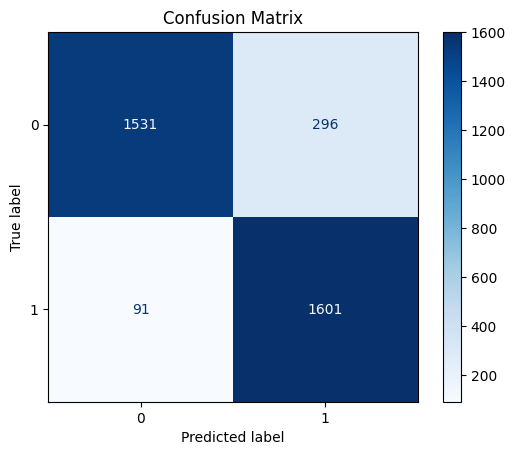

In [ ]:
# Confusion matrix
y_true = []
y_pred = []

for images, labels in test_data.unbatch().batch(32):
    preds = model.predict(images)
    y_true.extend(labels.numpy())
    y_pred.extend((preds > optimal_threshold).astype(int).flatten())

# Convert to NumPy arrays
y_true = np.array(y_true)
y_pred = np.array(y_pred)

# Create confusion matrix
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [ ]:
# Makes and stores predictions for all test images
y_true = []
y_pred_probs = []
images_list = []

# Collect predictions batch-by-batch
for images, labels in test_data.unbatch().batch(1):
    preds = model.predict(images, verbose=0)
    y_pred_probs.append(preds[0][0])
    y_true.append(labels.numpy()[0])
    images_list.append(images.numpy()[0])


/usr/local/lib/python3.11/dist-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


In [ ]:
# Finds all false positives and false negatives from predictions

false_positives = []
false_negatives = []

for i in range(len(y_true)):
    if y_true[i] == 0 and y_pred[i] == 1:
        false_positives.append((i, images_list[i], y_pred_probs[i]))
    elif y_true[i] == 1 and y_pred[i] == 0:
        false_negatives.append((i, images_list[i], y_pred_probs[i]))

print("Found", len(false_positives), "false positives.")
print("Found", len(false_negatives), "false negatives.")


Found 296 false positives.
Found 91 false negatives.


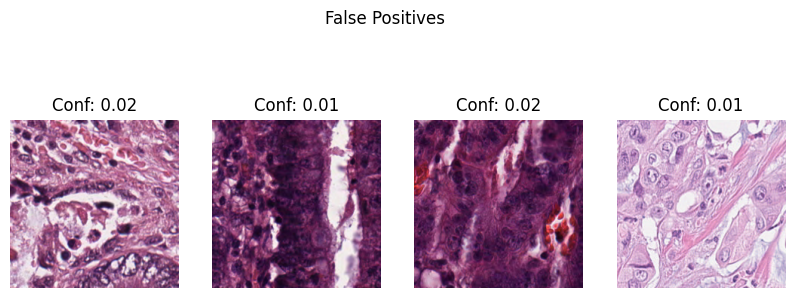

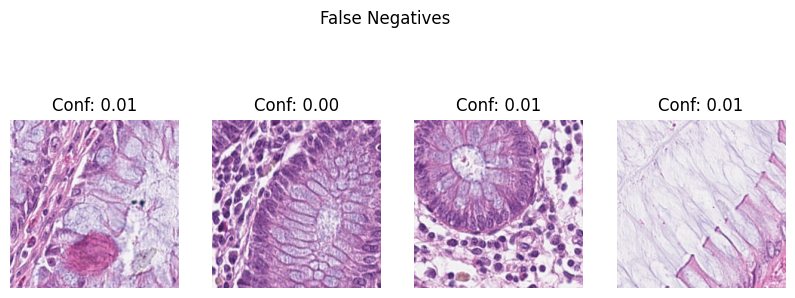

In [ ]:
# Shows examples of false positives and false negatives
import matplotlib.pyplot as plt

def show_examples(examples, title):
    plt.figure(figsize=(10, 4))
    for i in range(min(4, len(examples))):
        _, image, prob = examples[i]
        plt.subplot(1, 4, i+1)
        plt.imshow(image.astype("uint8"))
        plt.axis("off")
        plt.title(f"Conf: {prob:.2f}")
    plt.suptitle(title)
    plt.show()

show_examples(false_positives, "False Positives")
show_examples(false_negatives, "False Negatives")


In [ ]:
# finds all layer outputs
image_batch, label_batch = next(iter(test_data))
img = image_batch[1]
img = tf.expand_dims(img, axis=0)
layer_out=[]
layer_name=[]
for layer in model.layers:
    if isinstance(layer, (tf.keras.layers.Conv2D,tf.keras.layers.MaxPooling2D)):
        layer_out.append(layer.output)
        layer_name.append(layer.name)
layer_activations = tf.keras.Model(inputs=model.inputs,outputs=layer_out)
activations = layer_activations.predict(img)

/usr/local/lib/python3.11/dist-packages/keras/src/models/functional.py:237: UserWarning: The structure of `inputs` doesn't match the expected structure.
Expected: ['input_layer_1']
Received: inputs=Tensor(shape=(1, 224, 224, 3))
  warnings.warn(msg)


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 332ms/step


<ipython-input-12-0bbff4eab60d>:3: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`). Consider using `matplotlib.pyplot.close()`.
  plt.figure(figsize=(2,2))


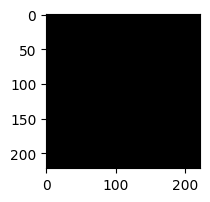

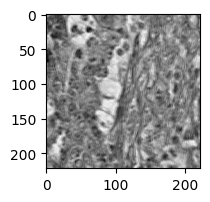

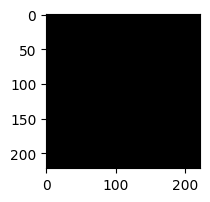

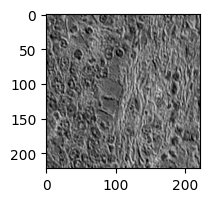

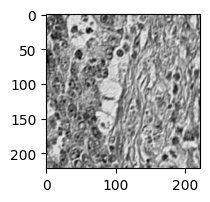

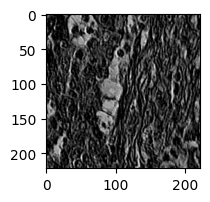

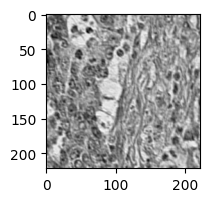

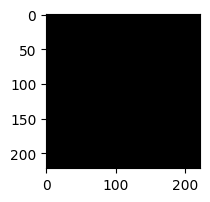

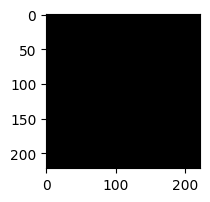

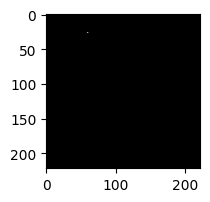

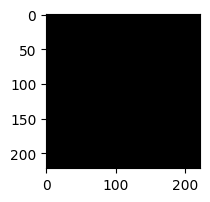

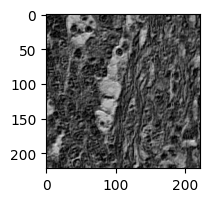

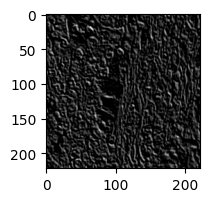

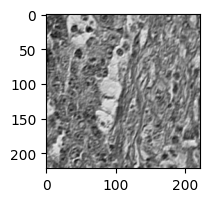

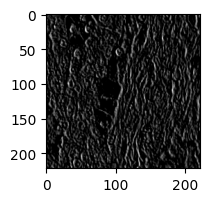

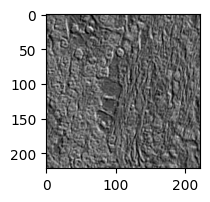

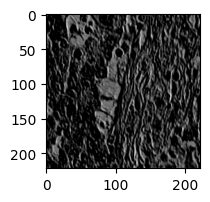

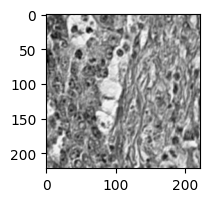

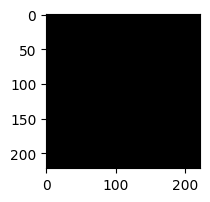

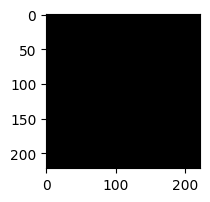

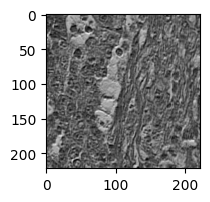

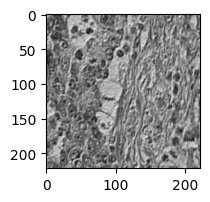

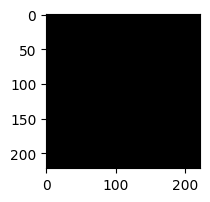

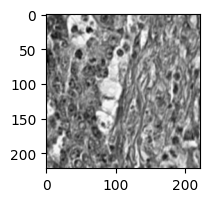

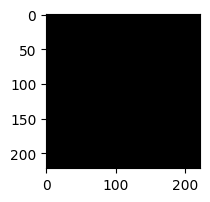

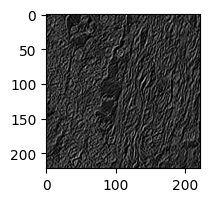

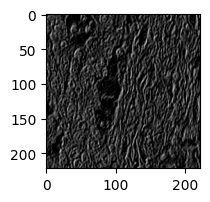

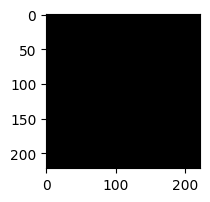

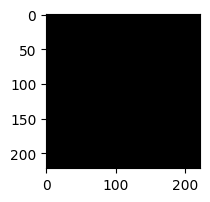

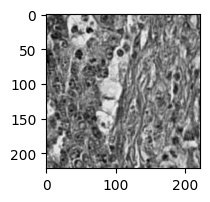

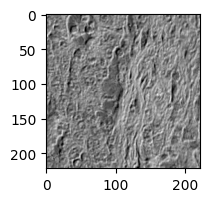

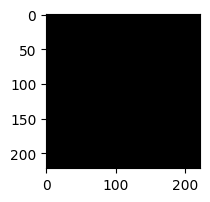

In [ ]:
# shows some layer outputs
for c in range(0, activations[0].shape[3]):
    layer_act = activations[0]
    plt.figure(figsize=(2,2))
    plt.imshow(layer_act[0,:,:,c],cmap='gray')

In [ ]:
# finds all filters for layer
filters, bias = model.layers[1].get_weights()
filters.shape

(3, 3, 3, 32)

In [ ]:
# shows all filters for layer
for ff in range(0,len(filters[0,0,0])):
    f = filters[:,:,:,ff]
    fig = plt.figure(figsize=(2,2))
    plt.imshow(f[:,:,0]+bias[ff],cmap='gray')
